In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


import time
import random
import torch
import gc
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import deepwave
from tqdm import tqdm
import gstools as gs
from gstools.random import MasterRNG

from svgdfwi.fwi import *
from svgdfwi.kernel import *
from svgdfwi.utils import *
from svgdfwi.annealing import *
from svgdfwi.svgd import *
from svgdfwi.plots import *
from svgdfwi.perturbations import *


import imageio
import pandas as pd
from tabulate import tabulate

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import hdbscan
from pylops.utils.metrics import snr


import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import matplotlib.colors as colors


# set seed
np.random.seed(10)
random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed_all(10)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
## Loading config and true model

from hydra import initialize, compose

with initialize(version_base=None, config_path="../config"):
    cfg = compose("config_example")
    
source_locations, receiver_locations, source_amplitudes, time_axis, xax, zax = setup_fwi_acquisition(cfg, device=device)
    
nz = cfg.params.nz
nx = cfg.params.nx
dx  = cfg.params.dx
m_vmin = cfg.params.m_vmin
m_vmax = cfg.params.m_vmax
std_min, std_max = 0, 800

# True model
model_true = np.load('../data/marmousi_portion.npy', allow_pickle=True).astype('float32')
out_path = f'../figures/paper/clusters/'

## Tanh - RBF

In [14]:
# Selecting the experiment
exp_id = f"{3:02d}"
results = np.load(f'../results/exp/{exp_id}_exp/{exp_id}_results_svgd.npz', allow_pickle=True)

# selecting particles of the last update
particles = results['updates'][-1].astype('float32')
num_particles, particle_dimensions = particles.shape

# Scale particles if needed
scaler = StandardScaler()
# X_scaled = scaler.fit_transform(particles)
X_scaled = np.copy(particles)

# HDBSCAN on original dims data
clusterer = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=2)  # Adjust min_cluster_size if needed
labels = clusterer.fit_predict(X_scaled)

# reduce dimensionality for visualization
pca_2d = PCA(n_components=2)
X_pca = pca_2d.fit_transform(X_scaled)


In [15]:
## Separate data by clusters
unique_labels = np.unique(labels)
clusters = {label: particles[labels == label] for label in unique_labels}

# Print the number of particles in each cluster
for label, cluster_data in clusters.items():
    print(f"Cluster {label}: {cluster_data.shape[0]} particles")

Cluster -1: 35 particles
Cluster 0: 163 particles
Cluster 1: 2 particles


In [16]:
## SNR values of each cluster
snr_values_by_cluster = []

for label in unique_labels:
    particles_cluster = np.copy(clusters[label])
    outputs = np.copy(particles_cluster.reshape(particles_cluster.shape[0], nz, nx))

    # SNR of all particles in the current cluster
    snr_cluster = np.zeros(particles_cluster.shape[0])
    for i in range(particles_cluster.shape[0]):
        snr_cluster[i] = snr(outputs[i], model_true)

    snr_values_by_cluster.append(snr_cluster)

## data structure for seaborn violin plot
data = []
for label, snr_cluster in zip(unique_labels, snr_values_by_cluster):
    for snr_value in snr_cluster:
        data.append((label, snr_value))

df = pd.DataFrame(data, columns=['Cluster', 'SNR'])


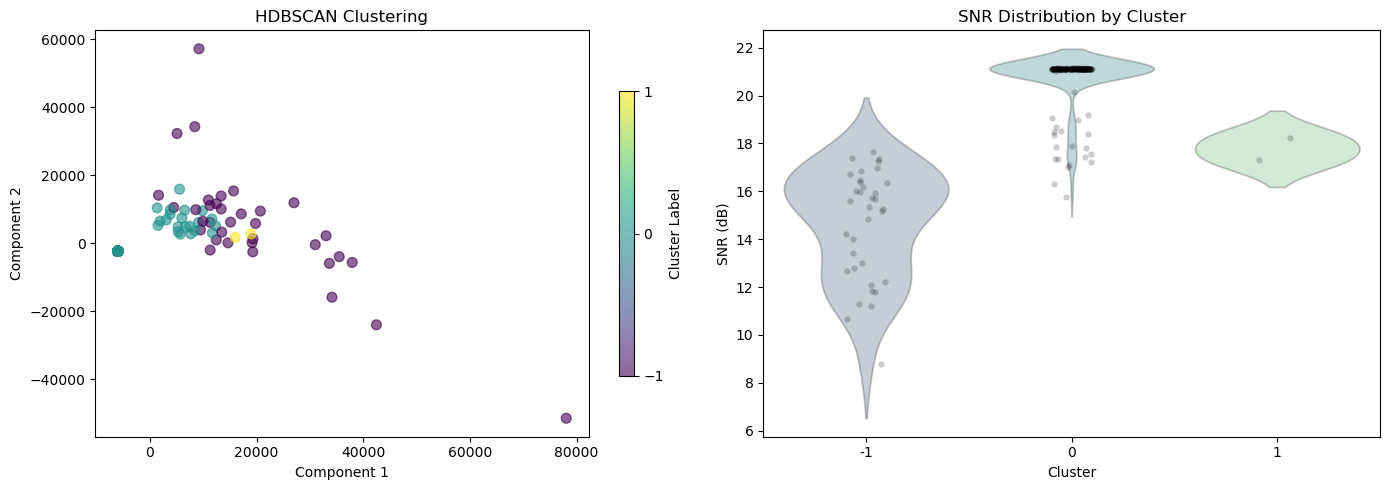

In [17]:
plt.rcParams['font.size'] = '10'
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

## HDBSCAN clustering
sc = axs[0].scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', marker='o', alpha=0.6, s=50)
axs[0].set_title('HDBSCAN Clustering')
axs[0].set_xlabel('Component 1')
axs[0].set_ylabel('Component 2')
cbar = plt.colorbar(sc, ax=axs[0], shrink=0.7, ticks=unique_labels)
cbar.set_label('Cluster Label')


## Violin plot for SNR values across clusters
palette = sns.color_palette("viridis", len(np.unique(labels)))
sns.violinplot(x='Cluster', y='SNR', data=df, palette=palette, inner=None, alpha=0.3, ax=axs[1])


for label in np.unique(labels):
    sns.stripplot(x='Cluster', y='SNR', data=df[df['Cluster'] == label], jitter=True, color='k', size=4.5, alpha=0.2, ax=axs[1])

axs[1].set_xlabel('Cluster')
axs[1].set_ylabel('SNR (dB)')
axs[1].set_title('SNR Distribution by Cluster')

plt.tight_layout()
plt.savefig(f'{out_path}exp_{exp_id}_HDBSCAN_cluster_SNR.png', bbox_inches='tight', dpi=150)
plt.show()

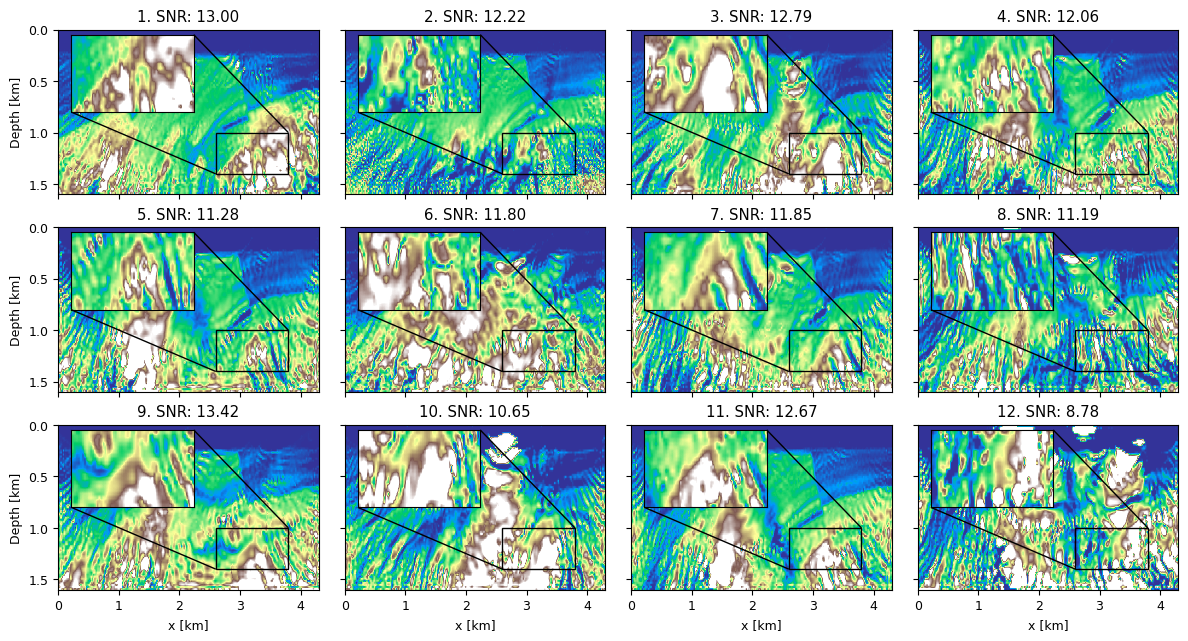

In [18]:
## Plotting particles cluster 
indices_low_snr = np.where(snr_values_by_cluster[0]<14.0)[0] #indices of the noise cluster


particles_cluster = np.copy(clusters[-1][indices_low_snr])
outputs = np.copy(particles_cluster.reshape(particles_cluster.shape[0], nz, nx))
plt.rcParams['font.size'] = '9'
idx = np.linspace(0, 11, 12, dtype=int)
# idx = np.linspace(50, 61, 12, dtype=int)
cmap = 'terrain'
fig = plt.figure(figsize=(14, 7))  
gs = gridspec.GridSpec(3, 4,  
                       left=0.1, right=0.9, bottom=0.1, top=0.9,
                       wspace=0.1, hspace=0.2)
ax0 = fig.add_subplot(gs[0, 0])
ax0.tick_params(axis="x", labelbottom=False)
ax0.set_ylabel("Depth [km]")
ax1 = fig.add_subplot(gs[0, 1])
ax1.tick_params(axis="x", labelbottom=False)
ax1.tick_params(axis="y", labelleft=False)
ax2 = fig.add_subplot(gs[0, 2], sharey=ax0)
ax2.tick_params(axis="x", labelbottom=False)
ax2.tick_params(axis="y", labelleft=False)
ax3 = fig.add_subplot(gs[0, 3])
ax3.tick_params(axis="x", labelbottom=False)
ax3.tick_params(axis="y", labelleft=False)
ax4 = fig.add_subplot(gs[1, 0])
ax4.tick_params(axis="x", labelbottom=False)
ax4.set_ylabel("Depth [km]")
ax5 = fig.add_subplot(gs[1, 1])
ax5.tick_params(axis="x", labelbottom=False)
ax5.tick_params(axis="y", labelleft=False)
ax6 = fig.add_subplot(gs[1, 2])
ax6.tick_params(axis="x", labelbottom=False)
ax6.tick_params(axis="y", labelleft=False)
ax7 = fig.add_subplot(gs[1, 3])
ax7.tick_params(axis="x", labelbottom=False)
ax7.tick_params(axis="y", labelleft=False)
ax8 = fig.add_subplot(gs[2, 0])
ax8.set_ylabel("Depth [km]")
ax8.set_xlabel("x [km]")
ax9 = fig.add_subplot(gs[2, 1])
ax9.tick_params(axis="y", labelleft=False)
ax9.set_xlabel("x [km]")
ax10 = fig.add_subplot(gs[2, 2])
ax10.tick_params(axis="y", labelleft=False)
ax10.set_xlabel("x [km]")
ax11 = fig.add_subplot(gs[2, 3])
ax11.tick_params(axis="y", labelleft=False)
ax11.set_xlabel("x [km]")
# extent = (0, outputs[idx[0]].shape[1], outputs[idx[0]].shape[0], 0)
extent = (0,(nx-1)*dx*1e-3, (nz-1)*dx*1e-3,0)
# extent_zoom = (130, 190, 50, 70)
extent_zoom = (2.6, 3.8, 1.0, 1.4)
for i, j in zip(np.arange(12), [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11]):
    j.imshow(outputs[idx[i]], vmin=m_vmin, vmax=m_vmax, cmap=cmap, extent=extent)
    j.set_title(f'{i+1}. SNR: {snr(outputs[idx[i]], model_true):.2f}')
    j.axis('tight')
    axins = j.inset_axes([0.05, 0.5, 0.47, 0.47])  # Zoom window in the upper left
    axins.imshow(outputs[idx[i]], vmin=m_vmin, vmax=m_vmax, cmap="terrain", extent=extent)
    axins.axis('tight')
    x1, x2, y1, y2 = extent_zoom
    axins.set_xlim(x1, x2)
    axins.set_ylim(y2, y1)
    axins.set_xticks([])
    axins.set_yticks([])
    _patch, pp1, pp2 = mark_inset(j, axins, loc1=2, loc2=4, fc="none", ec="black")
    pp1.loc1, pp1.loc2 = 1, 4
    pp2.loc1, pp2.loc2 = 3, 2


plt.savefig(f'{out_path}exp_{exp_id}_particles_cluster_noise.png', bbox_inches='tight', dpi=150)
plt.show()


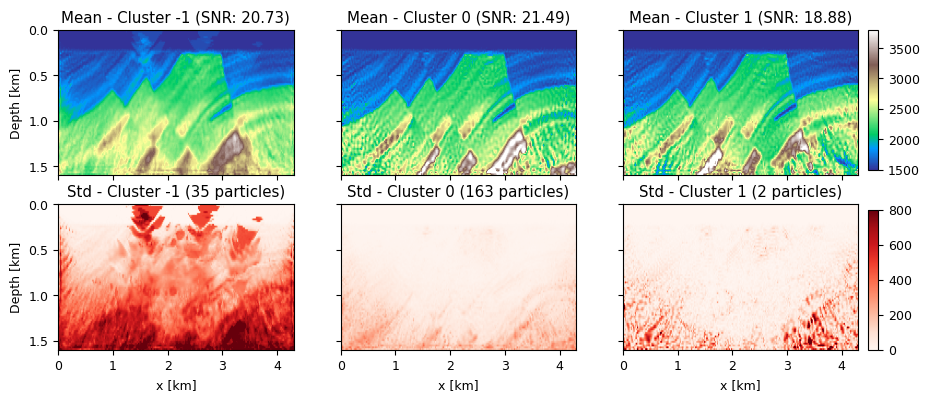

In [19]:
# Plotting mean and std per cluster
plt.rcParams['font.size'] = '9'
cmap = 'terrain'
fig = plt.figure(figsize=(10, 4))  
num_clusters = len(unique_labels)
rows = 2 
cols = num_clusters  
gs = gridspec.GridSpec(rows, cols,  
                       left=0.1, right=0.9, bottom=0.1, top=0.9,
                       wspace=0.2, hspace=0.2)

extent = (0,(nx-1)*dx*1e-3, (nz-1)*dx*1e-3,0)
for idx, label in enumerate(unique_labels):
    col = idx

    mean = clusters[label].mean(0).reshape(nz, nx)
    std = clusters[label].std(0).reshape(nz, nx)

    ax_mean = fig.add_subplot(gs[0, col])
    im_mean = ax_mean.imshow(mean, vmin=m_vmin, vmax=m_vmax, cmap=cmap, extent=extent)
    ax_mean.set_title(f'Mean - Cluster {label} (SNR: {snr(mean, model_true):.2f})')
    ax_mean.axis('tight')
    ax_mean.tick_params(axis="x", labelbottom=False)
    ax_mean.tick_params(axis="y", labelleft=False)
    if col == 0:
        ax_mean.set_ylabel("Depth [km]")
        ax_mean.tick_params(axis="y", labelleft=True)
        

    ax_std = fig.add_subplot(gs[1, col], sharey=ax_mean)
    im_std = ax_std.imshow(std, vmin=std_min, vmax=std_max, cmap='Reds', extent=extent)
    ax_std.set_title(f'Std - Cluster {label} ({clusters[label].shape[0]} particles)')
    ax_std.axis('tight')
    ax_std.tick_params(axis="y", labelleft=False)
    if col == 0:
        ax_std.set_ylabel("Depth [km]")
        ax_std.tick_params(axis="y", labelleft=True)
        
    ax_std.set_xlabel("x [km]")

# Add colorbars
cbar_ax_mean = fig.add_axes([0.91, 0.55, 0.01, 0.35])  
fig.colorbar(im_mean, cax=cbar_ax_mean)

cbar_ax_std = fig.add_axes([0.91, 0.1, 0.01, 0.35])   
fig.colorbar(im_std, cax=cbar_ax_std)

plt.savefig(f'{out_path}exp_{exp_id}_mean_std_clusters.png', bbox_inches='tight', dpi=150)
plt.show()